In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### DATA IMPORTATION

In [3]:
data = pd.read_csv('claim_data_group3_2024.csv')
# make IDpol the index
data.set_index('IDpol', inplace=True)
data

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
1093259.0,0.0,1.00,C,6.0,2.0,76.0,62.0,B12,Regular,306.0,R82,0.0
5026741.0,0.0,0.54,F,5.0,3.0,56.0,50.0,B12,Diesel,27000.0,R11,0.0
1081095.0,0.0,0.25,C,7.0,3.0,36.0,50.0,B5,Diesel,222.0,R24,0.0
3062789.0,0.0,1.00,C,6.0,4.0,58.0,69.0,B1,Regular,229.0,R53,0.0
4114350.0,0.0,1.00,A,4.0,14.0,67.0,50.0,B2,Regular,10.0,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6069891.0,0.0,0.52,A,4.0,1.0,63.0,95.0,B12,Regular,42.0,R74,0.0
6009212.0,0.0,0.70,E,10.0,5.0,65.0,52.0,B12,Regular,4348.0,R72,0.0
4013191.0,0.0,0.36,D,6.0,3.0,51.0,50.0,B12,Diesel,1955.0,R94,0.0


### DATA VISUALIZATION

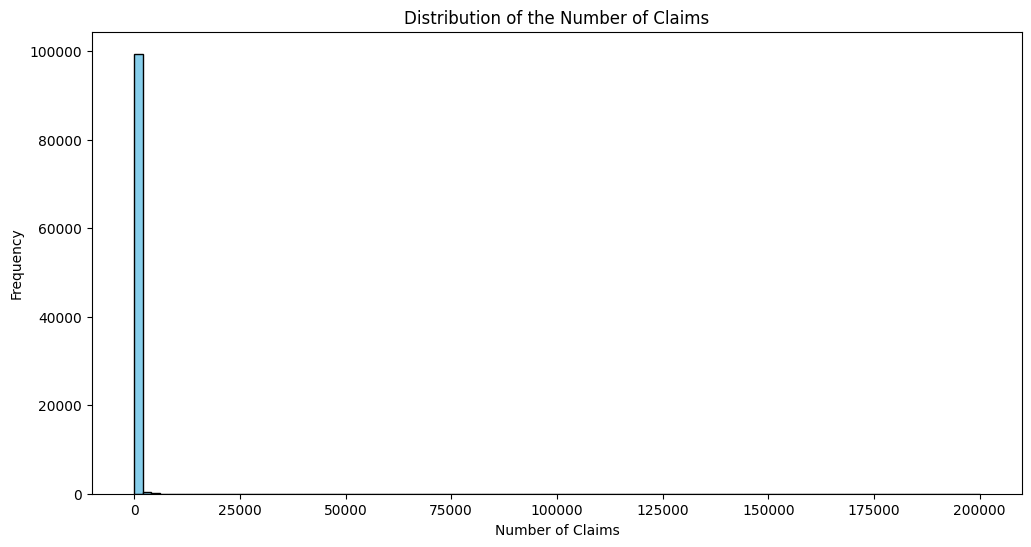

In [4]:
plt.figure(figsize=(12, 6))
plt.hist(data['ClaimAmount'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Number of Claims')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of Claims')
plt.show()

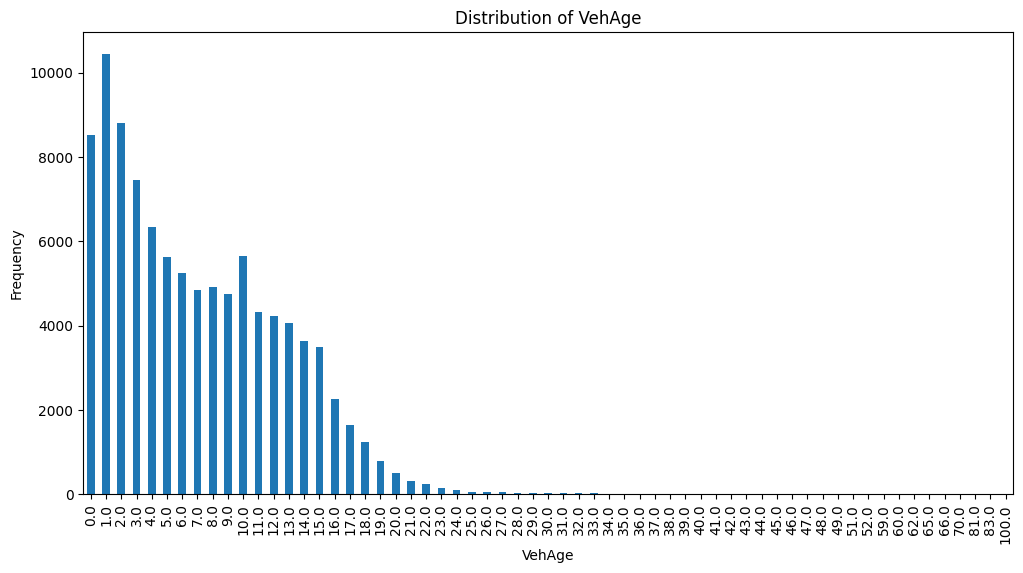

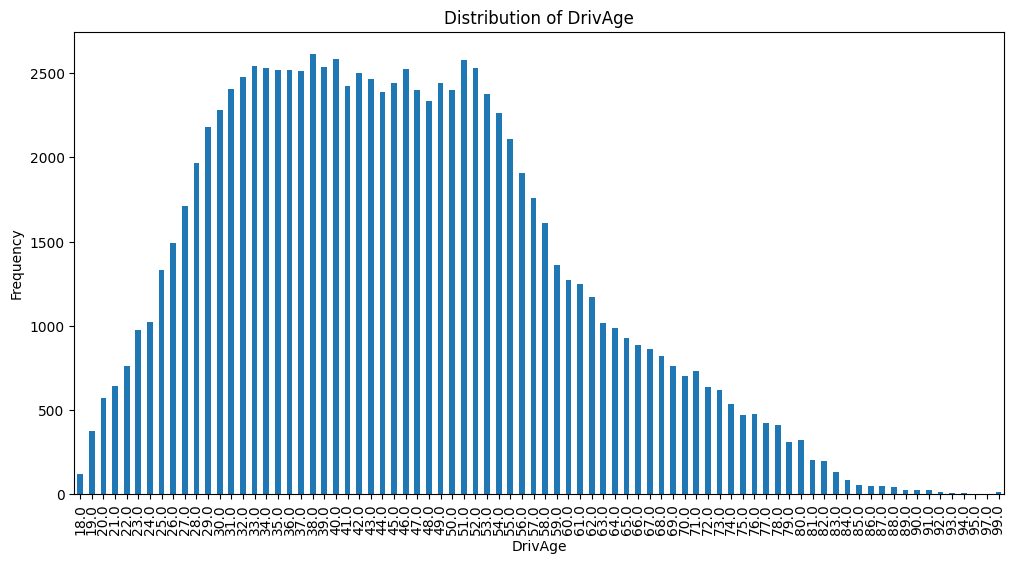

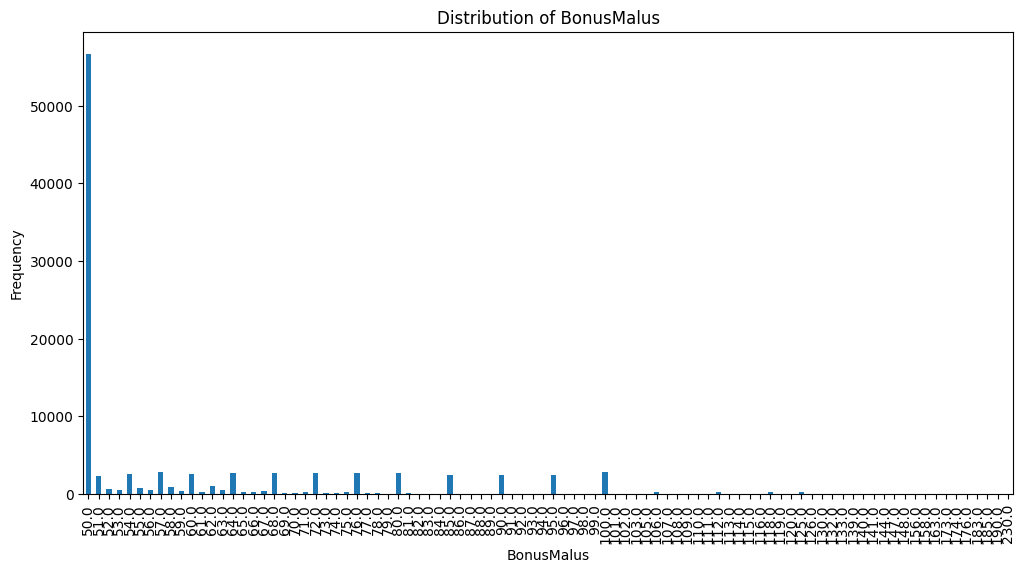

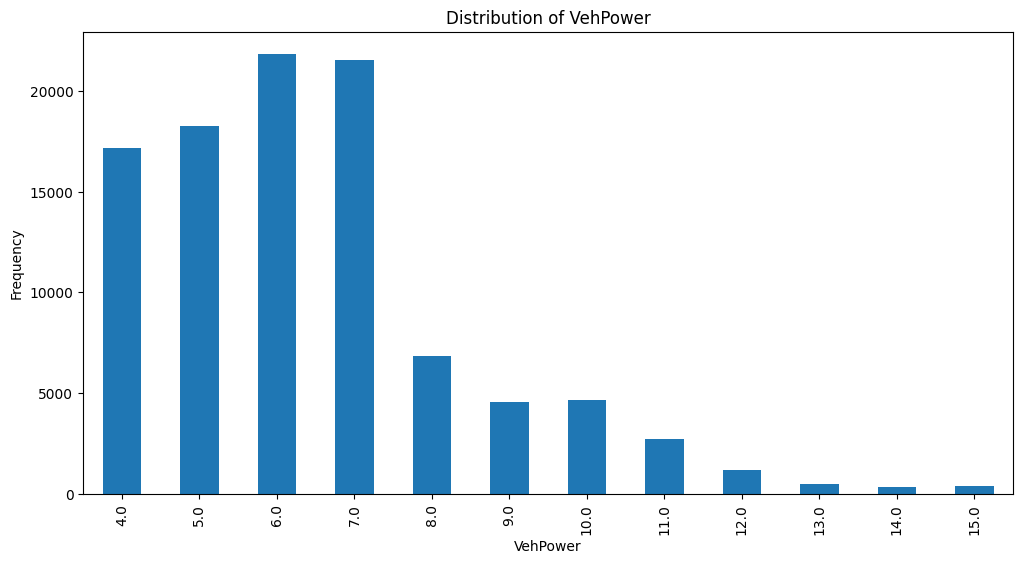

In [5]:
vars = ['VehAge', 'DrivAge', 'BonusMalus','VehPower']
for var in vars:
    data.groupby(var).size().plot(kind='bar', figsize=(12, 6))
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.title('Distribution of ' + var)
    plt.show()


### TRAIN and VALIDATION SETS

In [6]:
train_data, valid_data = train_test_split(data, test_size=0.3, random_state=42)

### RISK CLASSIFICATION ALGORITHM

### PREDICTING TOTAL LOSSES